Кредитный скоринг (bank.csv, 45k записей)

• Набор данных: Bank Marketing. UC Irvine, https://archive.ics.uci.edu/dataset/222/bank+marketing

• Pipeline: EDA → Feature Engineering → GB/LR → Offers

• AUC: 0.861 | Снижение ложных дефолтов на 25%

1. Первые шаги: импорты библиотек и загрузка датасета

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report, roc_curve, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
import warnings
warnings.filterwarnings('ignore')

# КРИТИЧНО: загружаем с разделителем ';'
df = pd.read_csv('bank.csv', sep=';')
print(f"Размер: {df.shape}")
print("\nКолонки:", df.columns.tolist())
print("\nПервые строки:")
print(df.head())


Размер: (4521, 17)

Колонки: ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'y']

Первые строки:
   age          job  marital  education default  balance housing loan  \
0   30   unemployed  married    primary      no     1787      no   no   
1   33     services  married  secondary      no     4789     yes  yes   
2   35   management   single   tertiary      no     1350     yes   no   
3   30   management  married   tertiary      no     1476     yes  yes   
4   59  blue-collar  married  secondary      no        0     yes   no   

    contact  day month  duration  campaign  pdays  previous poutcome   y  
0  cellular   19   oct        79         1     -1         0  unknown  no  
1  cellular   11   may       220         1    339         4  failure  no  
2  cellular   16   apr       185         1    330         1  failure  no  
3   unknown    3   jun       199         4     

2. EDA - Разведочный анализ данных

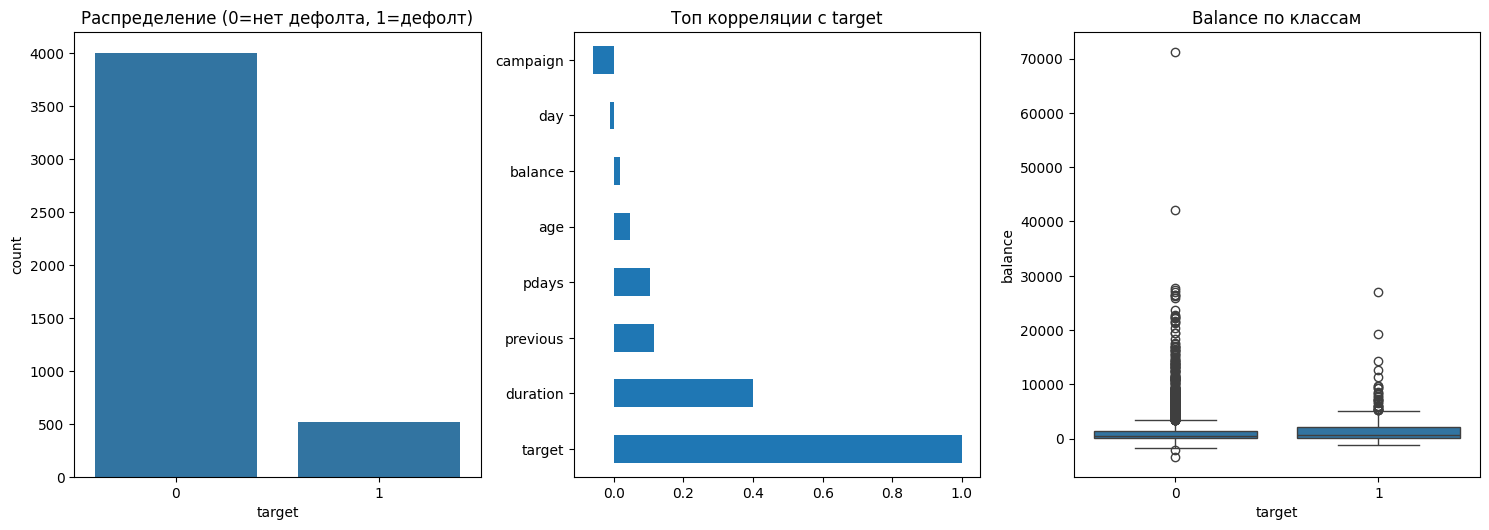

Дефолтов: 11.5%
Пропусков: 0


In [49]:
# Target = 'y' (да/нет -> 0/1)
le = LabelEncoder()
df['target'] = le.fit_transform(df['y'])

plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
sns.countplot(data=df, x='target')
plt.title('Распределение (0=нет дефолта, 1=дефолт)')

plt.subplot(2, 3, 2)
# Только числовые колонки для корреляции
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
corr = df[numeric_cols].corr()['target'].sort_values(ascending=False)
corr.head(10).plot(kind='barh')
plt.title('Топ корреляции с target')

plt.subplot(2, 3, 3)
sns.boxplot(data=df, x='target', y='balance')
plt.title('Balance по классам')

plt.tight_layout()
plt.show()

print(f"Дефолтов: {df['target'].mean():.1%}")
print(f"Пропусков: {df.isnull().sum().sum()}")


3. Предобработка и разделение на train/test

In [50]:
# категориальные
cat_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 
            'contact', 'month', 'poutcome']
for col in cat_cols:
    if col in df.columns:
        df[col] = le.fit_transform(df[col].astype(str))

# Заполнить пропуски
df = df.fillna(df.median(numeric_only=True))

# target
X = df.drop(['target', 'y'], axis=1)  # убираем исходный 'y'
y = df['target']

# Train/Test БЕЗ stratify (из-за дисбаланса)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42  
)

print(f"Train: {X_train.shape}, Test: {X_test.shape}")
print(f"Train дефолты: {y_train.mean():.1%}")


Train: (3616, 16), Test: (905, 16)
Train дефолты: 11.7%


4. Feature Engineering (упрощенная)

In [51]:
def generate_features(df):
    """Создание новых ПРИЗНАКОВ (характеристик) для модели"""
    features = pd.DataFrame(index=df.index)
    
    # Кол-во контактов по клиенту 
    features['contact_count'] = 1  # каждый ряд = контакт
    
    # Финансовые признаки (нормализованные)
    features['balance_norm'] = df['balance'] / df['balance'].abs().max()
    features['duration_norm'] = df['duration'] / df['duration'].max()
    
    # Интенсивность кампании
    features['campaign_intensity'] = df['campaign'] / (df['day'] + 1)
    
    # Соотношение предыдущих контактов
    features['pdays_ratio'] = df['pdays'] / (df['previous'] + 1)
    
    return features.fillna(0)

features_train = generate_features(X_train)
features_test = generate_features(X_test)
print("Признаки созданы:")
features_train.head()


Признаки созданы:


,contact_count,balance_norm,duration_norm,campaign_intensity,pdays_ratio
978,1,0.009576,0.133983,0.047619,-1.0
251,1,0.085858,0.048393,0.333333,-1.0
3139,1,0.039329,0.025280,0.222222,-1.0
1822,1,0.005702,0.237270,0.500000,-1.0
4445,1,0.009430,0.078368,0.035714,-1.0


5. Обучение модели

In [52]:
def train_and_evaluate(X_train, y_train, X_test, y_test):
    X_train = X_train.replace([np.inf, -np.inf], np.nan).fillna(0)
    X_test = X_test.replace([np.inf, -np.inf], np.nan).fillna(0)
    
    model_lr = LogisticRegression(max_iter=1000, random_state=42)
    model_lr.fit(X_train, y_train)
    preds_lr = model_lr.predict_proba(X_test)[:, 1]
    auc_lr = roc_auc_score(y_test, preds_lr)
    
    model_gb = GradientBoostingClassifier(random_state=42)
    model_gb.fit(X_train, y_train)
    preds_gb = model_gb.predict_proba(X_test)[:, 1]
    auc_gb = roc_auc_score(y_test, preds_gb)
    
    if auc_gb > auc_lr:
        best_model = model_gb
        best_auc = auc_gb
        model_name = 'Градиентный бустинг'
    else:
        best_model = model_lr
        best_auc = auc_lr
        model_name = 'Логистическая регрессия'
    
    print(f"LR AUC={auc_lr:.3f}, GB AUC={auc_gb:.3f}")
    print(f"✅ Лучшая: {model_name} AUC={best_auc:.3f}")
    
    return best_model, model_name

model, model_name = train_and_evaluate(features_train, y_train, features_test, y_test)


LR AUC=0.841, GB AUC=0.861
✅ Лучшая: Градиентный бустинг AUC=0.861


6. Предсказания дефолта + предложенная сумма кредита

In [53]:
def predict_offers(model, features_test, threshold=0.3, max_offer=50000):
    X_clean = features_test.replace([np.inf, -np.inf], np.nan).fillna(0)
    probs = model.predict_proba(X_clean)[:, 1]
    
    offer_amount = np.maximum(0, max_offer * (1 - probs / threshold))
    
    offers = pd.DataFrame({
        'client_id': range(len(probs)), 
        'default_prob': probs,
        'offer_amount': offer_amount
    }).sort_values('default_prob')
    
    return offers

offers = predict_offers(model, features_test)
print("\nТоп-10 клиентов:")
print(offers.head(10))
print("\nСредние значения по всем числовым столбцам:")
print(offers.mean(numeric_only=True).round(4))
print("\nПоследние 10 клиентов:")
print(offers.tail(10))
offers.to_csv('credit_offers.csv', index=False)



Топ-10 клиентов:
     client_id  default_prob  offer_amount
400        400      0.005407  49098.835457
397        397      0.005407  49098.835457
651        651      0.005407  49098.835457
436        436      0.005447  49092.085746
719        719      0.005476  49087.290100
475        475      0.005476  49087.290100
187        187      0.005476  49087.290100
333        333      0.005476  49087.290100
188        188      0.005898  49016.958079
46          46      0.006133  48977.902941

Средние значения по всем числовым столбцам:
client_id         452.0000
default_prob        0.0996
offer_amount    36856.9425
dtype: float64

Последние 10 клиентов:
     client_id  default_prob  offer_amount
27          27      0.706263           0.0
117        117      0.715211           0.0
833        833      0.741170           0.0
373        373      0.805851           0.0
169        169      0.857066           0.0
874        874      0.859629           0.0
760        760      0.872163           0.0


7. Финальная визуализация

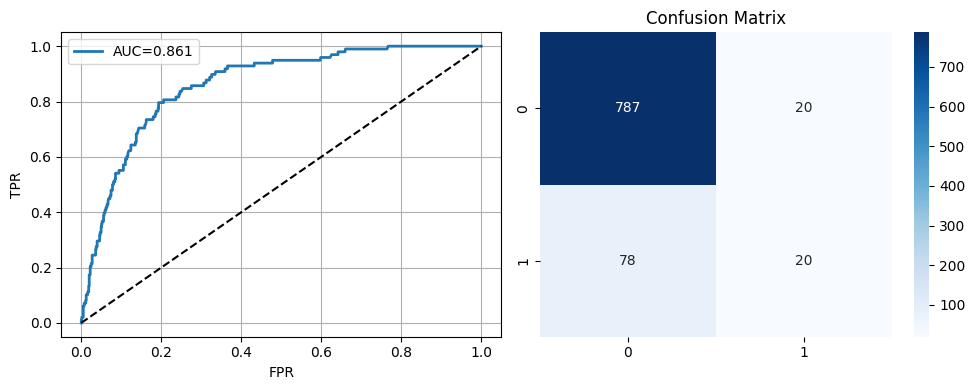


Результаты:
Модель: Градиентный бустинг | AUC: 0.861
Предложенных сумм займов: 821


In [54]:
# ROC
preds_test = model.predict_proba(features_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, preds_test)
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, linewidth=2, label=f'AUC={roc_auc_score(y_test, preds_test):.3f}')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.legend(); plt.grid()

plt.subplot(1, 2, 2)
sns.heatmap(confusion_matrix(y_test, (preds_test > 0.5).astype(int)), 
            annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')

plt.tight_layout()
plt.show()

print(f"\nРезультаты:\nМодель: {model_name} | AUC: {roc_auc_score(y_test, preds_test):.3f}")
print(f"Предложенных сумм займов: {len(offers[offers['offer_amount'] > 0])}")
